# Register of renewable energy power plants in Germany

This is a Jupyter Notebook that downloads and cleans up the data from the project [EnergyMap.info](http://www.energymap.info/) and  the German Federal Network Agency for Electricity, Gas, Telecommunications, Posts and Railway [BNetzA](http://www.bundesnetzagentur.de/). EnergyMap.info provides a register of all renewable energy power plants in Germany.

Since 2014 the BNetzA is responsible to publish the register of renewable power plants due to the [EEG 2014 (German)](http://www.gesetze-im-internet.de/eeg_2014/) [(English)](http://www.res-legal.eu/search-by-country/germany/single/s/res-e/t/promotion/aid/feed-in-tariff-eeg-feed-in-tariff/lastp/135/). Note: From June 2014 on all power plants are published in two seperated MS Excel-files for roof mounted PV systems and all other renewable power plants.

The register includes all RE power plants which are eligible for the German feed-in tariff (according to the EEG law). EnergyMap.info collects all data which is mandatorily reported from the four German TSO's to the BNetzA and merges it. Additionally EnergyMap.info validates and converts the data to a standard format.


New links:

https://www.netztransparenz.de/de/Anlagenstammdaten.htm 


# License

* This notebook is published under the GNU GPL v3 license. http://www.gnu.org/licenses/gpl-3.0.en.html.
* This notebook is developed by the project OPSD
* http://open-power-system-data.org/

# Table of contents 

* [Register of renewable energy power plants in Germany](#Register-of-renewable-energy-power-plants-in-Germany)
* [License](#Licence)
* [Import python modules](#Import-python-modules)
* [Data overview](#Data-overview)
* [Download and extract data](#Download-an-extracting-data-from-data-sources)
    * [Unzip and load data as Data Frame](#Unzip-and-load-data-as-data-frame)
    * [Definition of column names](#Definition-of-column-names)
    * [First look at the Data Frame structure and format](#First-look-at-the-Data-Frame-structure-and-format)
    * [Rename values by own english standards](#Rename-values-by-own-english-standards)

* [Find duplicantes and other suspect data](#Find-duplicantes-and-other-suspect-data)

* [Georeferencing get coordinates](#Georeferencing-get-coordinates)
* [Geoploting test](#Geoplot-testing)
* [Documenting the data package in a JSON object](#Documenting-the-data-package-in-a-JSON-object)
* [Write Data Package to disk](#Write-Data-Package-to-disk)


# Import Python modules

In [1]:
%matplotlib inline


from collections import OrderedDict
import io
import json
import os
import subprocess
import zipfile
import posixpath
import urllib.parse
import urllib.request
import matplotlib.pyplot as plt
from mpl_toolkits.basemap import Basemap
import numpy as np
import pandas as pd
import requests
import yaml  # http://pyyaml.org/, pip install pyyaml, conda install pyyaml
import datetime  



#create download and output folder if they do not exist
if not os.path.exists('input/'): os.makedirs('input/')
if not os.path.exists('output/'): os.makedirs('output/')
if not os.path.exists('output/datapackage_renewables'): os.makedirs('output/datapackage_renewables')


# Data overview

## EnergyMap.info

* Data discription from source: http://www.energymap.info/download/
* Download from: http://www.energymap.info/download/eeg_anlagenregister_2015.08.utf8.csv.zip
    * Last Update: 08.2015
    * File sides: 51,9 MB

## Netztransparenz.de 

German TSO transparenty page of 50Hertz, Amprion, TenneT and TransnetBW.
* [Netztransparenz](https://www.netztransparenz.de/de/Anlagenstammdaten.htm)

* Download: [zip-File](https://www.netztransparenz.de/de/file/UeNB-EEG-Anlagenstammdaten_2013.zip)
    * Last Update: 06.11.2015
    * File sides: 363,9 MB
    
##  Bundesnetzagentur (BNetzA)

German Federal Network Agency for Electricity, Gas, Telecommunications, Posts and Railway (BNetzA) publish the renewable power plant register ("Anlagenregister"): [PV](http://www.bundesnetzagentur.de/cln_1422/DE/Sachgebiete/ElektrizitaetundGas/Unternehmen_Institutionen/ErneuerbareEnergien/Photovoltaik/DatenMeldgn_EEG-VergSaetze/DatenMeldgn_EEG-VergSaetze_node.html) and [other renewables](http://www.bundesnetzagentur.de/cln_1422/DE/Sachgebiete/ElektrizitaetundGas/Unternehmen_Institutionen/ErneuerbareEnergien/Datenerhebung_EEG/Datenerhebung_EEG-node.html) renewable energy power plants.

# Download an extracting data from data sources

In the beginning we using EnergyMap.info for all historical data.

In [2]:
# Energymap.info as referenc
url_energymap = 'http://www.energymap.info/download/eeg_anlagenregister_2015.08.utf8.csv.zip'
# netztransparenz.de
url_netztransp  ='https://www.netztransparenz.de/de/file/Anlagenstammdaten_2014_4UeNB.zip'
# BNetzA register
url_bnetza ='http://www.bundesnetzagentur.de/SharedDocs/Downloads/DE/Sachgebiete/Energie/' \
            'Unternehmen_Institutionen/ErneuerbareEnergien/Anlagenregister/VOeFF_Anlagenregister/' \
            '2015_11_Veroeff_AnlReg.xls?__blob=publicationFile&v=1'
# BNetzA PV register 
url_bnetza_pv = 'https://www.bundesnetzagentur.de/SharedDocs/Downloads/DE/' \
                'Sachgebiete/Energie/Unternehmen_Institutionen/ErneuerbareEnergien/' \
                'Photovoltaik/Datenmeldungen/Meldungen_Aug-Okt2015.xls?__blob=publicationFile&v=1'


In [3]:
# Download function from TU Berlin
def downloadandcache(url):
    """This function downloads a file into a folder called 
    downloads and returns the local filepath."""
    path = urllib.parse.urlsplit(url).path
    filename = posixpath.basename(path)
    now = datetime.datetime.now()
    datestring = ""
    datestring = str(now.year)+"-"+str(now.month)
    filepath = "input/"+datestring+"-"+filename
    
    #check if file exists, otherwise download it
    if os.path.exists(filepath) == False:
        print("Downloading file", filename)
        urllib.request.urlretrieve(url, filepath)
    else:
        print("Using local file from", filepath)
    filepath = ''+filepath
    return filepath

In [4]:
# Use download function and get file path
energymap_filepath = downloadandcache(url_energymap)
bnetza_filepath = downloadandcache(url_bnetza)
bnetza_pv_filepath = downloadandcache(url_bnetza_pv)
netztransp_filepath = downloadandcache(url_netztransp)

Using local file from input/2016-2-eeg_anlagenregister_2015.08.utf8.csv.zip
Using local file from input/2016-2-2015_11_Veroeff_AnlReg.xls
Using local file from input/2016-2-Meldungen_Aug-Okt2015.xls
Using local file from input/2016-2-Anlagenstammdaten_2014_4UeNB.zip


## Unzip and load data as data frame

We are creating a [pandas DataFrame](http://pandas.pydata.org/pandas-docs/stable/dsintro.html#dataframe) in order to handle our data.

--> Time for loading data: approx. 5-10 min.

In [5]:
# unzip netztransparenz.de
z = zipfile.ZipFile(netztransp_filepath)
# read csv of Amprion
amprion_df = pd.read_csv(z.open('Amprion_Anlagenstammdaten_2014.csv'),
                       sep=';',        # CSV field separator, default is ','
                       thousands='.',  # Thousands separator, default is ','
                       decimal=',',    # Decimal separator, default is '.'
                       header=0,
                       parse_dates=[11,12,13,14], 
                       encoding = 'cp850',
                       dayfirst=True, 
                       low_memory=False)

In [6]:
# read csv of 50Hertz
hertz_df = pd.read_csv(z.open('50Hertz_Anlagenstammdaten_2014.csv'),
                       sep=';',        # CSV field separator, default is ','
                       thousands='.',  # Thousands separator, default is ','
                       decimal=',',    # Decimal separator, default is '.'
                       header=0,
                       parse_dates=[11,12,13,14],  
                       encoding = 'cp1252',
                       dayfirst=True, 
                       low_memory=False)


In [7]:
# read csv of TenneT
tennet_df = pd.read_csv(z.open('TenneT_Anlagenstammdaten_2014.csv'),
                       sep=';',        # CSV field separator, default is ','
                       thousands='.',  # Thousands separator, default is ','
                       decimal=',',    # Decimal separator, default is '.'
                       header=0,
                       parse_dates=[11,12,13,14], 
                       encoding = 'cp1252',
                       dayfirst=True, 
                       low_memory=False)

In [8]:
# read csv of TenneT
transnetbw_df = pd.read_csv(z.open('TransnetBW_Anlagenstammdaten_2014.csv'),
                       sep=';',        # CSV field separator, default is ','
                       thousands='.',  # Thousands separator, default is ','
                       decimal=',',    # Decimal separator, default is '.'
                       header=0,
                       parse_dates=[11,12,13,14], 
                       encoding = 'cp1252',
                       dayfirst=True, 
                       low_memory=False)

In [9]:
# unzip energymap zip file
zz = zipfile.ZipFile(energymap_filepath)
# read csv of energymap
enmap_df = pd.read_csv(zz.open('eeg_anlagenregister_2015.08.utf8.csv'),
                       sep=';',        # CSV field separator, default is ','
                       thousands='.',  # Thousands separator, default is ','
                       decimal=',',    # Decimal separator, default is '.'
                       header=None,
                       names=None,
                       parse_dates=[0], 
                       dayfirst=True, 
                       comment='#',
                       low_memory=False)

In [10]:
# read BNetzA register
bnetza = pd.ExcelFile(bnetza_filepath)
#bnetza.sheet_names
bnetza_df = bnetza.parse("Gesamtübersicht")
#list(bnetza1.columns)

In [11]:
# read BNetzA PV roof mounted
bnetza_pv = pd.ExcelFile(bnetza_pv_filepath)

# Combine all sheets into one DataFrame
bnetza_pv_df = pd.concat(bnetza_pv.parse(sheet, skiprows=10
                         ) for sheet in bnetza_pv.sheet_names)
# drop NULL "Unnamed:" column
bnetza_pv_df = bnetza_pv_df.drop(bnetza_pv_df.columns[[7]], axis=1)
# show sheet names
bnetza_pv.sheet_names

['August 2014',
 'September 2014',
 'Oktober 2014',
 'November 2014',
 'Dezember 2014',
 'Januar 2015',
 'Februar 2015',
 'März 2015',
 'April 2015',
 'Mai 2015',
 'Juni 2015',
 'Juli 2015',
 'August 2015',
 'September 2015',
 'Oktober 2015']

In [12]:
#bnetza_df.Meldedatum.min()

## Definition of column names

Here we translate the original column names from EnergyMap.info, the four German TSO's and the BNetzA from German to English. The new English column names are assigned to our data frame. 

In [13]:
# translation of column names by csv list
columnnames =pd.read_csv('input/column_translation_list.csv',sep = ";",
                           header=0)
columndict = columnnames.set_index('original_name')['column_naming'].to_dict()
energymap_dict = columnnames.loc[columnnames['source'] == 'energymap',
                                 'column_naming'].to_dict()

In [14]:
# get an overview of the list by source
columnnames.loc[columnnames['source'] == 'bnetza_pv']
#columnnames.groupby('source').count()

,original_name,column_naming,translation,source
95,Anlage \nBundesland,federal_state,federal state,bnetza_pv
96,Anlage \nOrt oder Gemarkung,city,"Place, city, village",bnetza_pv
97,Anlage \nPLZ,postcode,Post code or ZIP,bnetza_pv
98,Anlage \nStraße oder Flurstück *),street_address,Street name and house number,bnetza_pv
99,Inbetriebnahmedatum **),start_up_date,Start-up date,bnetza_pv
100,Installierte \nNennleistung [kWp],rated_power,Installed rated power,bnetza_pv
101,Meldungsdatum,notification_date,notification date,bnetza_pv


In [15]:
# rename 
bnetza_pv_df.rename(columns = columndict , inplace=True)
# because of douple backslash in a python dict we need a additional helping dict
backslash ={'Anlage \nBundesland': 'federal_state','Anlage \nOrt oder Gemarkung': 
            'city','Anlage \nPLZ': 'postcode','Anlage \nStraße oder Flurstück *)': 
            'street_address', 'Installierte \nNennleistung [kWp]': 'rated_power'}
bnetza_pv_df.rename(columns = backslash, inplace=True)
bnetza_pv_df.columns

Index(['federal_state', 'city', 'postcode', 'street_address', 'start_up_date',
       'rated_power', 'notification_date'],
      dtype='object')

In [16]:
# rename bnetza_df columns by the traslation dict
bnetza_df.rename(columns = columndict , inplace=True)
#bnetza_df.columns

In [17]:
# rename columns
transnetbw_df.rename(columns = columndict , inplace=True)
tennet_df.rename(columns = columndict , inplace=True)
amprion_df.rename(columns = columndict , inplace=True)
hertz_df.rename(columns = columndict , inplace=True)
enmap_df.rename(columns = energymap_dict , inplace=True)

## Set original source to dataframe
* Set Source names
* Make changes with the PV solar roff mounted 
    * Add new eeg_id  

In [18]:
# set source names of each dataframe
#enmap_df['source'] = 'EnergyMap'
transnetbw_df['source'] = 'TransnetBW'
tennet_df['source'] = 'TenneT'
amprion_df['source'] = 'Amprion'
hertz_df['source'] = '50Hertz'
bnetza_df['source'] = 'BNetzA'
bnetza_pv_df['source'] = 'BNetzA_PV'
enmap_df['source'] = 'energymap'

In [19]:
# Add type of generation 
bnetza_pv_df['type_of_generation'] = 'solar_roof_mounted'
# Add new id for eeg_id by the index
bnetza_pv_df['eeg_id'] =  'pv_id' + bnetza_pv_df.index.astype(str)

In [20]:
# join dataframes together
f_enmap = [enmap_df, bnetza_df, bnetza_pv_df]
f_tso = [transnetbw_df,tennet_df, amprion_df, 
         hertz_df, bnetza_df, bnetza_pv_df]

# keys?
renewables = pd.concat(f_tso)#, keys=['TransnetBW','TenneT',
                             #'Amprion','50Hertz','BNetzA','BNetzA_PV'])
enmap = pd.concat(f_enmap) #, keys=['Energymap','BNetzA','BNetzA_PV'])


## Select columns of our interest

In [21]:
# locate used columns
column_interest = ['start_up_date', 'rated_power','type_of_generation',
                   'subtype','thermal_capacity','city', 'postcode',
                   'street_address','tso','utm_zone','utm_east', 'utm_north',
                   'gps_lon','gps_lat', 'notification_reason', 'eeg_id',
                   'dso_id', 'dso','voltage_level','decommissioning','source']


In [22]:
renewables = renewables.loc[:, column_interest]
energymap = enmap.loc[:, column_interest]

# delete the rest of columns
renewables.reset_index(drop=True)
energymap.reset_index(drop=True)
print('done')

done


## Take a look of entries and source
 


In [23]:
renewables.groupby(['source'])['eeg_id'].count()

source
50Hertz       145575
Amprion       456292
BNetzA          4675
BNetzA_PV      68827
TenneT        672226
TransnetBW    309121
Name: eeg_id, dtype: int64

In [24]:
energymap.groupby(['source'])['eeg_id'].count()

source
BNetzA          4675
BNetzA_PV      68827
energymap    1560376
Name: eeg_id, dtype: int64

## First look at the Data Frame structure and format

Here we look at the created Data Frame and the data formats of the different columns.

`DataFrame.info()` shows us the number of non-null (non-NA) values in each column, which can serve as a first indicator that something went wrong in a column

In [25]:
energymap.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1640770 entries, 0 to 4512
Data columns (total 21 columns):
start_up_date          1639585 non-null datetime64[ns]
rated_power            1635687 non-null float64
type_of_generation     1635690 non-null object
subtype                1157532 non-null object
thermal_capacity       1133 non-null float64
city                   1640756 non-null object
postcode               1640735 non-null object
street_address         1286275 non-null object
tso                    1559527 non-null object
utm_zone               6239 non-null float64
utm_east               6235 non-null float64
utm_north              6235 non-null float64
gps_lon                1551492 non-null float64
gps_lat                1551492 non-null float64
notification_reason    6505 non-null object
eeg_id                 1633878 non-null object
dso_id                 0 non-null float64
dso                    1566788 non-null object
voltage_level          1566819 non-null object
de

## Rename values by own english standards

* use translation csv file
* create subtypes of generation


In [26]:
# translation of entries values 
values =pd.read_csv('input/value_translation_list.csv',sep = ";",
                           header=0)
# create dict in order change values 
valuedict = values.set_index('original_name')['subtype'].to_dict()
# 
gentypedict = values.set_index('subtype')['type_of_generation'].to_dict()

In [27]:
print(values)

                   original_name                  subtype type_of_generation
0                      Wind Land             wind_onshore               wind
1                       Wind See            wind_offshore               wind
2                        Klärgas               gas_sewage                gas
3                      Grubengas                 gas_mine                gas
4                  Freifläche PV     solar_ground_mounted              solar
5                     Deponiegas             gas_landfill                gas
6                       Biomasse                  biomass            biomass
7                    Wasserkraft                    hydro              hydro
8                            Gas                      gas                gas
9                       Erdwärme               geothermal         geothermal
10                   Wasserkraft                    hydro              hydro
11                     Windkraft             wind_onshore               wind

In [28]:
# replace values by standard values
# running time ~ 10 min
renewables.replace(valuedict, inplace=True)
energymap.replace(valuedict, inplace=True)

In [29]:
# subtypes = type_of_generation
renewables.subtype = renewables.type_of_generation

In [30]:
# replace subtypes by types
renewables.type_of_generation.replace(gentypedict, inplace=True)
energymap.type_of_generation.replace(gentypedict, inplace=True)
# get an overview
renewables.groupby(['type_of_generation'])['rated_power'].sum() / 1000

type_of_generation
#NV               8.002000
biomass        7807.764700
gas             621.206020
geothermal       33.988500
hydro          1773.302181
solar         39531.409606
wind          51528.177923
Name: rated_power, dtype: float64

In [31]:
renewables.groupby(['subtype'])['rated_power'].sum() / 1000

subtype
#NV                         8.002000
biomass                  7807.764700
gas_landfill              230.923120
gas_mine                  288.110000
gas_sewage                102.172900
geothermal                 33.988500
hydro                    1773.302181
solar_ground_mounted      466.736481
solar_roof_mounted      39064.673125
wind_offshore            3967.176000
wind_onshore            47561.001923
Name: rated_power, dtype: float64

In [32]:
renewables.groupby(['source'])['eeg_id'].count()

source
50Hertz       145575
Amprion       456292
BNetzA          4675
BNetzA_PV      68827
TenneT        672226
TransnetBW    309121
Name: eeg_id, dtype: int64

In [33]:
energymap.groupby(['source'])['eeg_id'].count()

source
BNetzA          4675
BNetzA_PV      68827
energymap    1560376
Name: eeg_id, dtype: int64

In [34]:
energymap.groupby(['type_of_generation'])['rated_power'].sum()/1000

type_of_generation
biomass        7848.673073
gas             662.781140
geothermal       33.643000
hydro          1698.479681
solar         38957.410956
wind          54413.321300
Name: rated_power, dtype: float64

# Find duplicantes and other suspect data

* find duplicated power_plant_id
* take the last entry of a duplicate 
* find and drop entries with decommissioning time
* delete pv_roof_mounted <= 2014-12-31 from BNetzA_PV
* postcode len() < 5 add zero
* check notification_reason
* delete #NV value for type of generation

Post codes have to be a string value because some starts with a zero, so we remove any float type and check for invalid  post codes.

In [35]:
# function for adding zero
addzero = lambda a,b: b if (a !=4) else '0'+b

In [36]:
# change postcode               
# convert int to string for postcode
renewables['postcode']= renewables['postcode'].apply(str)
renewables['postcode_new']= renewables['postcode'].apply(str)
#count lenght of string
renewables['postcode_len'] = renewables.postcode.str.len()

# reset index
renewables = renewables.reset_index()
# locate len = 4 and add 0 to postcode
renewables['postcode_new']=renewables[['postcode_len','postcode']
                                      ].apply(lambda x: addzero(x[0], x[1]), axis=1)

In [37]:
# change postcode  
# convert int to string for postcode
energymap['postcode']= energymap['postcode'].apply(str)
energymap['postcode_new']= energymap['postcode'].apply(str)
#count lenght of string
energymap['postcode_len'] = energymap.postcode.str.len()

# reset index
energymap = energymap.reset_index()
# locate len = 4 and add 0 to postcode
energymap['postcode_new']=energymap[['postcode_len','postcode']
                                    ].apply(lambda x: addzero(x[0], x[1]), axis=1)

In [38]:
# drop and rename post code columns
renewables.drop(['postcode_len','postcode','index'], axis=1, inplace=True)
renewables.rename(columns={'postcode_new': 'postcode'}, inplace=True)

energymap.drop(['postcode_len','postcode','index'], axis=1, inplace=True)
energymap.rename(columns={'postcode_new': 'postcode'}, inplace=True)


## Drop suspect data 

* Order Dataframe by date in order to take the last given value if duplicates are given

In [39]:
# sort index by start_up_date
renewables = renewables.ix[pd.to_datetime(renewables.start_up_date).order().index]
renewables.head()

/home/leppi/anaconda3/lib/python3.4/site-packages/ipykernel/__main__.py:2: FutureWarning: order is deprecated, use sort_values(...)
  from ipykernel import kernelapp as app


,start_up_date,rated_power,type_of_generation,subtype,thermal_capacity,city,street_address,tso,utm_zone,utm_east,...,gps_lon,gps_lat,notification_reason,eeg_id,dso_id,dso,voltage_level,decommissioning,source,postcode
250164,1895-11-16,70.000,hydro,hydro,NaN,NaN,NaN,TransnetBW GmbH,NaN,NaN,...,NaN,NaN,NaN,E16869000000000,10001553,Stadtwerke Mengen,NS,NaT,TransnetBW,885XX
1012695,1899-11-01,240.000,hydro,hydro,NaN,NaN,NaN,Amprion,NaN,NaN,...,NaN,NaN,NaN,E30000000242363,10001212,Stadtwerke Radevormwald GmbH,MS,NaT,Amprion,424XX
191311,1899-12-30,29.375,solar,solar_roof_mounted,NaN,NaN,NaN,TransnetBW GmbH,NaN,NaN,...,NaN,NaN,NaN,E16568363000000,10000843,Netze BW GmbH,NS,NaT,TransnetBW,735XX
1217592,1899-12-31,13.000,hydro,hydro,NaN,NaN,NaN,Amprion,NaN,NaN,...,NaN,NaN,NaN,E30000000060527,10003764,WESTNETZ GmbH,NS,NaT,Amprion,573XX
27213,1899-12-31,490.000,hydro,hydro,NaN,NaN,NaN,TransnetBW GmbH,NaN,NaN,...,NaN,NaN,NaN,E17149000000000,10000346,Stadtwerke Mühlacker GmbH,MS,NaT,TransnetBW,754XX


In [40]:
# drop BNetzA data which are older 2014-12-31
idx_date = renewables[(renewables['start_up_date'] <= '2014-12-31') 
                      & (renewables['source'] == 'BNetzA')].index
renewables.drop(idx_date,inplace=True)  

# Drop entires which are not installed jet
idx_no = renewables[(renewables['notification_reason']== 'Genehmigung')].index
renewables.drop(idx_no,inplace=True)

#get all duplicated eeg_id and take last entry
renewables.drop_duplicates(cols=['type_of_generation','start_up_date',
                                 'eeg_id'], keep='last',inplace=True)

# get all data from BNetzA_PV <= 2014-12-31 because of duplicated entries
idx_pv = renewables[(renewables['start_up_date'] <= '2014-12-31') 
                    & (renewables['source'] == 'BNetzA_PV')].index
renewables.drop(idx_pv,inplace=True)

# drop all entries where decommissioning is not null
idx_decom = renewables[renewables.decommissioning.notnull()].index
renewables.drop(idx_decom,inplace=True)

# delete #NV value for type of generation
idx_nv = renewables[(renewables['type_of_generation'] == '#NV')].index
renewables.drop(idx_nv,inplace=True)

print('done')
                                         

done


/home/leppi/anaconda3/lib/python3.4/site-packages/ipykernel/__main__.py:12: FutureWarning: the 'cols' keyword is deprecated, use 'subset' instead


In [41]:
renewables.groupby(['type_of_generation'])['rated_power'].sum() / 1000

type_of_generation
biomass        6781.629540
gas             552.477820
geothermal       33.988500
hydro          1624.171699
solar         38479.259784
wind          43440.678173
Name: rated_power, dtype: float64

In [42]:
renewables.groupby(['subtype'])['rated_power'].sum() / 1000

subtype
biomass                  6781.629540
gas_landfill              218.750120
gas_mine                  245.679000
gas_sewage                 88.048700
geothermal                 33.988500
hydro                    1624.171699
solar_ground_mounted      376.851555
solar_roof_mounted      38102.408229
wind_offshore            3478.276000
wind_onshore            39962.402173
Name: rated_power, dtype: float64

## Energymap dataframe as starting point

* We delete all data from energymap >= 2014-07-31
* Make new index by date

In [43]:
idx_date = energymap[(energymap['start_up_date'] >= '2014-07-31') 
                     & (energymap['source'] == 'energymap')].index
energymap.drop(idx_date,inplace=True)     


In [44]:
# sort index by start_up_date
energymap = energymap.ix[pd.to_datetime(energymap.start_up_date).order().index]
energymap.head()

/home/leppi/anaconda3/lib/python3.4/site-packages/ipykernel/__main__.py:2: FutureWarning: order is deprecated, use sort_values(...)
  from ipykernel import kernelapp as app


,start_up_date,rated_power,type_of_generation,subtype,thermal_capacity,city,street_address,tso,utm_zone,utm_east,...,gps_lon,gps_lat,notification_reason,eeg_id,dso_id,dso,voltage_level,decommissioning,source,postcode
261641,1895-11-16,70,hydro,NaN,NaN,Mengen,NaN,TransnetBW GmbH,NaN,NaN,...,9.346,48.069,NaN,E11553010100626210100001476300001,NaN,Stadtwerke Mengen,07 (NS),NaN,energymap,88512
1345866,1898-07-01,400,hydro,NaN,NaN,Fachbach,Elektrizitätswerk 0,Amprion GmbH,NaN,NaN,...,7.683,50.333,NaN,E31495010000000000060208028500000,NaN,Syna GmbH,05 (MS),NaN,energymap,56133
1246425,1899-11-01,240,hydro,NaN,NaN,Radevormwald,Wülfingstraße 6,Amprion GmbH,NaN,NaN,...,7.350,51.200,NaN,E3121201WA-WUELFINGSTRASSE--00001,NaN,Stadtwerke Radevormwald GmbH,05 (MS),NaN,energymap,42477
117094,1899-11-01,24,hydro,NaN,NaN,Zuzenhausen,NaN,TransnetBW GmbH,NaN,NaN,...,8.827,49.296,NaN,E11495010000000000060208118500000,NaN,Syna GmbH,07 (NS),NaN,energymap,74939
1555470,1899-12-30,400,hydro,NaN,NaN,"Königshain-Wiederau, OT Stein",Chemnitztalstr. 1,50Hertz Transmission GmbH,NaN,NaN,...,NaN,NaN,NaN,E41081010000000000000000000006028,NaN,Mitteldeutsche Netzgesellschaft Strom mbH,05 (MS),NaN,energymap,09306


In [45]:
# drop BNetzA data which are older 2014-12-31
idx_date = energymap[(energymap['start_up_date'] >= '2014-07-31') 
                     & (renewables['source'] == 'BNetzA')].index
energymap.drop(idx_date,inplace=True)  

# Drop entires which are not installed jet
idx_no = energymap[(energymap['notification_reason']== 'Genehmigung')].index
energymap.drop(idx_no,inplace=True)

# get all duplicated eeg_id and take last entry
energymap.drop_duplicates(cols=['type_of_generation','start_up_date',
                                'eeg_id'], keep='last',inplace=True)

# get all data from BNetzA_PV <= 2014-12-31 because of duplicated entries
idx_pv = energymap[(energymap['start_up_date'] <= '2014-07-31') 
                   & (energymap['source'] == 'BNetzA_PV')].index
energymap.drop(idx_pv,inplace=True)

# drop all entries where decommissioning is not null
idx_decom = energymap[energymap.decommissioning.notnull()].index
energymap.drop(idx_decom,inplace=True)

# delete #NV value for type of generation
idx_nv = energymap[(energymap['type_of_generation'] == '#NV')].index
energymap.drop(idx_nv,inplace=True)

print('done')

done


/home/leppi/anaconda3/lib/python3.4/site-packages/ipykernel/__main__.py:12: FutureWarning: the 'cols' keyword is deprecated, use 'subset' instead


In [46]:
energymap.groupby(['type_of_generation'])['rated_power'].sum() / 1000

type_of_generation
biomass        7234.954873
gas             637.061440
geothermal       30.143000
hydro          1671.942241
solar         38252.578274
wind          42244.717640
Name: rated_power, dtype: float64

In [47]:
renewables.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1602989 entries, 250164 to 1589595
Data columns (total 21 columns):
start_up_date          1602982 non-null datetime64[ns]
rated_power            1602989 non-null float64
type_of_generation     1602989 non-null object
subtype                1602989 non-null object
thermal_capacity       78 non-null float64
city                   39741 non-null object
street_address         3773 non-null object
tso                    1563248 non-null object
utm_zone               1666 non-null float64
utm_east               1666 non-null float64
utm_north              1666 non-null float64
gps_lon                0 non-null float64
gps_lat                0 non-null float64
notification_reason    1752 non-null object
eeg_id                 1602809 non-null object
dso_id                 1563248 non-null float64
dso                    1565000 non-null object
voltage_level          1564997 non-null object
decommissioning        0 non-null object
source       

In [48]:
energymap.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1605563 entries, 261641 to 1571819
Data columns (total 21 columns):
start_up_date          1605556 non-null datetime64[ns]
rated_power            1603645 non-null float64
type_of_generation     1603645 non-null object
subtype                1148207 non-null object
thermal_capacity       751 non-null float64
city                   1605563 non-null object
street_address         1260765 non-null object
tso                    1541479 non-null object
utm_zone               3847 non-null float64
utm_east               3843 non-null float64
utm_north              3843 non-null float64
gps_lon                1533402 non-null float64
gps_lat                1533402 non-null float64
notification_reason    4052 non-null object
eeg_id                 1603329 non-null object
dso_id                 0 non-null float64
dso                    1545582 non-null object
voltage_level          1545578 non-null object
decommissioning        0 non-null object
s

# Georeferencing get coordinates 

We are using the post code in order the make a rough geo-referencing. Since the TSO report only the first three digits of the poste code (e.g. 024xx) and no city or street name, we are only able to use the centroid of a post code region polygon as coordinates.

We using the three (#TSOs) and five digits (#BNetzA) postcode regions which are offered by www.suche-postleitzahl.org.

*  http://www.suche-postleitzahl.org/downloads?download=plz-gebiete.shp.zip
*  http://www.suche-postleitzahl.org/downloads?download_file=plz-3stellig.shp.zip
*  http://www.suche-postleitzahl.org/downloads#

License:

* http://www.suche-postleitzahl.org/downloads
* Open Database Licence frei zur Verfügung. 
* Quelle der Rohdaten: © OpenStreetMap contributors

With this data we have created a csv file with all kinds of post codes and created the gps latitude and longitude coordinates by using a PostgreSQL + PostGIS database. We added all possible TSO names to each post code including overlaps.
* SQL Script (will follow by link here)

In [49]:
# Get csv file
postcode = pd.read_csv('input/de_tso_postcode_gps.csv',
                       sep=';',        # CSV field separator, default is ','
                       header=0)

postcode.drop_duplicates(cols='postcode', keep='last',inplace=True)
postcode.head()

/home/leppi/anaconda3/lib/python3.4/site-packages/ipykernel/__main__.py:6: FutureWarning: the 'cols' keyword is deprecated, use 'subset' instead


,postcode,city,tso,gps_lon,gps_lat,geo_source
0,392XX,NaN,50Hertz Transmission GmbH,11.975520,52.081599,plz_3_digits
1,010XX,NaN,50Hertz Transmission GmbH,13.807068,51.084020,plz_3_digits
2,011XX,NaN,50Hertz Transmission GmbH,13.700503,51.085923,plz_3_digits
3,012XX,NaN,50Hertz Transmission GmbH,13.801462,51.011209,plz_3_digits
4,013XX,NaN,50Hertz Transmission GmbH,13.877194,51.040878,plz_3_digits


In [50]:
# take postcode and lon lat infomations
postcode= postcode[[0,1,3,4]]

In [51]:
# Clean dataframe
renewables.drop(['gps_lon','gps_lat'], axis=1, inplace=True)
renewables.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1602989 entries, 250164 to 1589595
Data columns (total 19 columns):
start_up_date          1602982 non-null datetime64[ns]
rated_power            1602989 non-null float64
type_of_generation     1602989 non-null object
subtype                1602989 non-null object
thermal_capacity       78 non-null float64
city                   39741 non-null object
street_address         3773 non-null object
tso                    1563248 non-null object
utm_zone               1666 non-null float64
utm_east               1666 non-null float64
utm_north              1666 non-null float64
notification_reason    1752 non-null object
eeg_id                 1602809 non-null object
dso_id                 1563248 non-null float64
dso                    1565000 non-null object
voltage_level          1564997 non-null object
decommissioning        0 non-null object
source                 1602989 non-null object
postcode               1602989 non-null object
dty

In [52]:
postcode = postcode.reset_index()
renewables = renewables.reset_index()

#### Merge geometry information by using the postcode

In [53]:
ren_geo =pd.merge(renewables, postcode, on=['postcode','city'],  how='left')

In [54]:
# rename columes
ren_geo.rename(columns={'gps_lon': 'longitude','gps_lat': 'latitude'}, inplace=True)


In [55]:
# How many couldn't be merged?
print('Missing coordinates ',ren_geo.latitude.isnull().sum())
# get an
ren_geo[ren_geo.latitude.isnull()].groupby(['type_of_generation','subtype'])['source'].count()

Missing coordinates  8660


type_of_generation  subtype             
biomass             biomass                   37
gas                 gas_landfill               1
hydro               hydro                      6
solar               solar_ground_mounted      47
                    solar_roof_mounted      7297
wind                wind_offshore            801
                    wind_onshore             471
Name: source, dtype: int64

### Energymap Data Frame


In [56]:
energymap.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1605563 entries, 261641 to 1571819
Data columns (total 21 columns):
start_up_date          1605556 non-null datetime64[ns]
rated_power            1603645 non-null float64
type_of_generation     1603645 non-null object
subtype                1148207 non-null object
thermal_capacity       751 non-null float64
city                   1605563 non-null object
street_address         1260765 non-null object
tso                    1541479 non-null object
utm_zone               3847 non-null float64
utm_east               3843 non-null float64
utm_north              3843 non-null float64
gps_lon                1533402 non-null float64
gps_lat                1533402 non-null float64
notification_reason    4052 non-null object
eeg_id                 1603329 non-null object
dso_id                 0 non-null float64
dso                    1545582 non-null object
voltage_level          1545578 non-null object
decommissioning        0 non-null object
s

In [57]:
# GEO REF energymap
postcode = postcode.reset_index()
energymap = energymap.reset_index()

energ_geo =pd.merge(energymap, postcode, on=['postcode','city'],  how='left')

In [58]:
# function using selecting longitude and latitude data. If energymap = NULL take postcode referenz
get_lonlat = lambda a,b: b if ( pd.isnull(a) == True) else a
# 
energ_geo['longitude'] = energ_geo[['gps_lon_x','gps_lon_y']].apply(lambda x:
                                    get_lonlat(x[0], x[1]), axis=1)
energ_geo['latitude'] = energ_geo[['gps_lat_x','gps_lat_y']].apply(lambda x: 
                                    get_lonlat(x[0], x[1]), axis=1)

In [59]:
# How many couldn't be merged?
print('Missing coordinates ',energ_geo.longitude.isnull().sum())
# get an
energ_geo[energ_geo.longitude.isnull()].groupby(['source','type_of_generation'])['source'].count()

Missing coordinates  21449


source     type_of_generation
BNetzA     biomass                 276
           gas                       2
           hydro                    47
           solar                    46
           wind                   1863
BNetzA_PV  solar                 11203
energymap  biomass                 103
           gas                       6
           hydro                    27
           solar                  6615
           wind                    636
Name: source, dtype: int64

#### ToDo:
* update postcode csv

In [60]:
# Clean Data Frame
energ_geo.drop(['index_x','index_y','level_0','gps_lon_y',
                'gps_lon_x','gps_lat_y','gps_lat_x'], axis=1, inplace=True)
energ_geo.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1605563 entries, 0 to 1605562
Data columns (total 21 columns):
start_up_date          1605556 non-null datetime64[ns]
rated_power            1603645 non-null float64
type_of_generation     1603645 non-null object
subtype                1148207 non-null object
thermal_capacity       751 non-null float64
city                   1605563 non-null object
street_address         1260765 non-null object
tso                    1541479 non-null object
utm_zone               3847 non-null float64
utm_east               3843 non-null float64
utm_north              3843 non-null float64
notification_reason    4052 non-null object
eeg_id                 1603329 non-null object
dso_id                 0 non-null float64
dso                    1545582 non-null object
voltage_level          1545578 non-null object
decommissioning        0 non-null object
source                 1605563 non-null object
postcode               1605563 non-null object
longitud

## More statistics for data valuation



In [61]:
energ_geo['rated_power'].describe()
# energ_geo.groupby(['type_of_generation'])['rated_power'].describe()

count    1603645.000000
mean          56.166669
std          367.893990
min            0.000000
25%            5.510000
50%            9.180000
75%           19.110000
max       135000.000000
Name: rated_power, dtype: float64

In [62]:
ren_geo['rated_power'].describe()
#ren_geo.groupby(['type_of_generation'])['rated_power'].describe()

count    1602989.000000
mean          56.714179
std          382.250203
min            0.000000
25%            5.510000
50%            9.200000
75%           19.200000
max       135000.000000
Name: rated_power, dtype: float64

In [63]:
#activ['rated_power'].sum() / 1000
ren_geo[(ren_geo['start_up_date'] >= '2014-12-31')].groupby(['type_of_generation'])['rated_power'].sum() / 1000

type_of_generation
biomass      12.467700
gas           1.186400
hydro         3.148540
solar      1086.271139
wind       4786.010960
Name: rated_power, dtype: float64

In [64]:

ren_geo.query("start_up_date <= '2014-12-31'").groupby(['type_of_generation'])['rated_power'].count()
#renewables.query("start_up_date <= '2014-12-31' & source == 'BNetzA_PV'").count()

type_of_generation
biomass         14419
gas               684
geothermal         10
hydro            7184
solar         1516786
wind            24112
Name: rated_power, dtype: int64

In [65]:
# Generation type by source and min date
ren_geo.groupby(['type_of_generation','source'])['start_up_date'].min()

type_of_generation  source    
biomass             50Hertz      1991-04-26
                    Amprion      1978-01-01
                    BNetzA       2015-01-01
                    TenneT       1987-04-01
                    TransnetBW   1966-09-01
gas                 50Hertz      1995-02-15
                    Amprion      1962-07-01
                    BNetzA       2015-02-19
                    TenneT       1981-06-01
                    TransnetBW   1911-01-01
geothermal          50Hertz      2004-08-13
                    Amprion      2007-11-22
                    TenneT       2009-02-03
                    TransnetBW   2009-10-23
hydro               50Hertz      1899-12-31
                    Amprion      1899-11-01
                    BNetzA       2015-01-14
                    TenneT       1900-01-01
                    TransnetBW   1895-11-16
solar               50Hertz      1899-12-31
                    Amprion      1988-02-01
                    BNetzA       2015-02-25
 

In [66]:
# Generation type by source and max date
ren_geo.groupby(['type_of_generation','source'])['start_up_date'].max()

type_of_generation  source    
biomass             50Hertz      2014-12-23
                    Amprion      2014-12-18
                    BNetzA       2015-11-24
                    TenneT       2014-12-29
                    TransnetBW   2015-12-19
gas                 50Hertz      2013-07-24
                    Amprion      2014-04-29
                    BNetzA       2015-10-29
                    TenneT       2014-06-26
                    TransnetBW   2012-08-21
geothermal          50Hertz      2004-08-13
                    Amprion      2012-10-13
                    TenneT       2014-09-25
                    TransnetBW   2009-10-23
hydro               50Hertz      2014-12-12
                    Amprion      2014-11-14
                    BNetzA       2015-11-19
                    TenneT       2014-12-16
                    TransnetBW   2014-11-07
solar               50Hertz      2014-12-31
                    Amprion      2014-12-31
                    BNetzA       2015-08-31
 

In [67]:
# growth rate 2014
rate14 = (ren_geo['start_up_date'] > '2014-01-01') & (ren_geo['start_up_date']
                                                      <= '2014-12-31')
ren_geo.loc[rate14].groupby(['subtype'])['rated_power'].sum() / 1000

subtype
biomass                211.586430
gas_landfill             2.188000
gas_sewage               0.259000
geothermal               3.500000
hydro                    5.952070
solar_roof_mounted    1571.884318
wind_offshore          371.900000
wind_onshore          4431.750033
Name: rated_power, dtype: float64

In [68]:
# Overview of early dates
ren_geo.query("start_up_date < '1980-01-01' & type_of_generation != 'hydro'")

,index_x,start_up_date,rated_power,type_of_generation,subtype,thermal_capacity,city,street_address,tso,utm_zone,...,eeg_id,dso_id,dso,voltage_level,decommissioning,source,postcode,index_y,longitude,latitude
2,191311,1899-12-30,29.375,solar,solar_roof_mounted,NaN,NaN,NaN,TransnetBW GmbH,NaN,...,E16568363000000,10000843,Netze BW GmbH,NS,NaT,TransnetBW,735XX,528,9.825670,48.819950
6,1530998,1899-12-31,6.010,solar,solar_roof_mounted,NaN,NaN,NaN,50hertz Transmission GmbH,NaN,...,E40000146905815,10001645,Mitteldeutsche Netzgesellschaft Strom mbH,NS,NaT,50Hertz,065XX,52,11.197351,51.477959
30,681,1905-07-01,5.700,solar,solar_roof_mounted,NaN,NaN,NaN,TransnetBW GmbH,NaN,...,E13485980000000,10000375,Technische Werke Friedrichshafen GmbH,NS,NaT,TransnetBW,880XX,625,9.558212,47.668658
59,29206,1911-01-01,500.000,gas,gas_sewage,NaN,NaN,NaN,TransnetBW GmbH,NaN,...,E11331000000000,10000386,Stadtwerke Bietigheim-Bissingen GmbH,MS,NaT,TransnetBW,743XX,534,9.092709,49.028082
749,1333777,1962-07-01,300.000,gas,gas_sewage,NaN,NaN,NaN,Amprion,NaN,...,E30000000421381,10002954,EWR Netz GmbH,NS,NaT,Amprion,686XX,492,8.460197,49.650652
1004,274275,1966-09-01,20000.000,biomass,biomass,NaN,NaN,NaN,TransnetBW GmbH,NaN,...,E11703160000000,10002846,Netrion GmbH,HS,NaT,TransnetBW,683XX,490,8.482258,49.544520
1287,1263747,1978-01-01,18910.000,biomass,biomass,NaN,NaN,NaN,Amprion,NaN,...,E30000000284698,10001624,Aschaffenburger Versorgungs-GmbH,HS,NaT,Amprion,638XX,452,9.261070,49.938397


In [69]:
energ_geo.query("start_up_date < '1980-01-01' & type_of_generation != 'hydro'")

,start_up_date,rated_power,type_of_generation,subtype,thermal_capacity,city,street_address,tso,utm_zone,utm_east,...,notification_reason,eeg_id,dso_id,dso,voltage_level,decommissioning,source,postcode,longitude,latitude
11,1900-01-01,400.00,gas,NaN,NaN,Bietigheim-Bissingen,NaN,TransnetBW GmbH,NaN,NaN,...,NaN,E1038601X0247400001Kläranlag00001,NaN,Stadtwerke Bietigheim-Bissingen GmbH,05 (MS),NaN,energymap,74321,9.133000,48.967000
33,1905-01-01,3.00,solar,solar_ground_mounted,NaN,Sindelfingen,NaN,TransnetBW GmbH,NaN,NaN,...,NaN,E10431010000105791045000S00300000,NaN,Stadtwerke Sindelfingen GmbH,07 (NS),NaN,energymap,71063,9.017000,48.700000
34,1905-01-01,1471.00,biomass,biogas,NaN,Nördlingen,NaN,TransnetBW GmbH,NaN,NaN,...,NaN,E12974010000000000000032734500001,NaN,Netze NGO GmbH,05 (MS),NaN,energymap,86720,10.500000,48.850000
35,1905-01-01,4.00,solar,solar_ground_mounted,NaN,Sigmaringen,NaN,TransnetBW GmbH,NaN,NaN,...,NaN,E11057010010101840014200501600016,NaN,Stadtwerke Sigmaringen,07 (NS),NaN,energymap,72488,9.217000,48.083000
36,1905-01-01,20.00,solar,solar_ground_mounted,NaN,Waldshut / Waldshut,NaN,TransnetBW GmbH,NaN,NaN,...,NaN,E11346010050108079005000S99900001,NaN,Stadtwerke Waldshut-Tiengen GmbH,07 (NS),NaN,energymap,79761,8.217000,47.617000
38,1905-01-01,5.00,solar,solar_ground_mounted,NaN,Lautern,NaN,TransnetBW GmbH,NaN,NaN,...,NaN,E12974010000000000000032774200001,NaN,Netze NGO GmbH,07 (NS),NaN,energymap,73540,9.983000,48.800000
39,1905-01-01,6.00,solar,solar_ground_mounted,NaN,Emmendingen,NaN,TransnetBW GmbH,NaN,NaN,...,NaN,E1113701000ZE000000270473RA000001,NaN,Stadtwerke Emmendingen GmbH,07 (NS),NaN,energymap,79312,7.850000,48.133000
40,1905-01-01,2.00,solar,solar_ground_mounted,NaN,Schorndorf,NaN,TransnetBW GmbH,NaN,NaN,...,NaN,E10060010736140000000000000050015,NaN,Stadtwerke Schorndorf GmbH,07 (NS),NaN,energymap,73614,9.533000,48.800000
43,1905-01-01,4.00,solar,solar_ground_mounted,NaN,Wolpertshausen,NaN,TransnetBW GmbH,NaN,NaN,...,NaN,E10358010000000000000001120300005,NaN,Netze BW GmbH,07 (NS),NaN,energymap,74549,9.845000,49.168000
54,1905-06-27,1053.00,biomass,NaN,NaN,Alerheim,NaN,TransnetBW GmbH,NaN,NaN,...,NaN,E1297401V000000000000034734000001,NaN,Netze NGO GmbH,05 (MS),NaN,energymap,86733,10.642000,48.850000


##  Plot  Overview of the first result

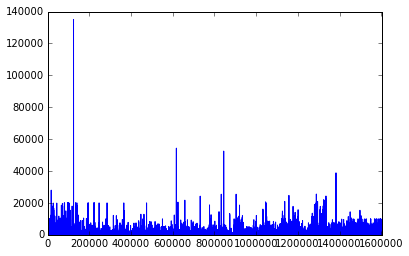

In [70]:
energ_geo['rated_power'].plot()

In [71]:

idx = pd.date_range(start='2005-01-01', end='2015-12-31', freq='D')
data = pd.DataFrame(index=idx)
data['capacity_pv_50Hertz']= 'Code für Summe über PV-Kapazität in 50Hertz Regelzone zu Stichtag einfügen'
data_to_merge_with_other_timeseries = data.resample('15min', fill_method='ffill')

## Take a look into the statistics of BMWI and BNetzA

In [72]:
# BNetzA
url_eeg2013 ='http://www.bundesnetzagentur.de/SharedDocs/Downloads/DE/'\
             'Sachgebiete/Energie/Unternehmen_Institutionen/ErneuerbareEnergien/' \
              'ZahlenDatenInformationen/EEGinZahlen_2013.xls;?__blob=publicationFile&v=3'
eeg2013 = pd.ExcelFile(url_eeg2013)
eeg2013.sheet_names

['Inhaltsverzeichnis',
 '1. Allgemeine Erläuterungen',
 '2.1 Überblick Deutschland',
 '2.2 Überblick Bundesländer',
 '2.3 Letzverbraucherabsatz',
 '2.4 Historische Entwicklung',
 '3.1 Wind onshore',
 '3.2 Wind offshore',
 '3.3 PV insgesamt',
 '3.4 PV Kategorien',
 '3.5 Biomasse',
 '3.6 Wasser',
 '3.7 Sonstige Energieträger',
 '4.1 Regelzonen',
 '4.2 Anschlussebenen',
 '4.3 Größenklassen',
 '5. Vermiedene NE']

In [73]:
sta2013 = eeg2013.parse('2.1 Überblick Deutschland', skiprows=4, skip_footer=9)
sta2013

,Unnamed: 0,Wasser,DKG-Gas*,Biomasse,Geothermie,Wind onshore,Wind offshore,Solar,Unnamed: 8
0,Installierte Leistung ingesamt (in MW),1487.23,551.15,6052.43,30.485,33456.7,508.3,36710.1,78796.4
1,Neuinbetriebnahmen (in MW),76.0051,0.658,167.197,11.315,2900.46,240,2643.31,6038.94
2,Installierte Anlagen insgesamt (Anzahl),6972,686,13420,8,22746,113,1429860,1473805
3,Eingespeiste Jahresarbeit (GWh),6265.11,1775.74,36258.4,79.8633,50802.7,904.818,28785.1,124872
4,Vergütungszahlungen (Mio.€),420.232,48.1669,6158.38,18.6547,3523.23,122.603,9346.04,19637.3
5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6,Angaben nach Vergütungsarten 2013,Erneuerbare Energieträger nach dem EEG,NaN,NaN,NaN,NaN,NaN,NaN,Summe
7,NaN,Wasser,DKG-Gas*,Biomasse,Geothermie,Wind onshore,Wind offshore,Solar,NaN
8,Feste Einspeisevergütung nach § 16 EEG 2012,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [74]:
url_reg2014  ='http://www.erneuerbare-energien.de/EE/Redaktion/DE/Downloads/zeitreihen-zur-entwicklung-der' \
             '-erneuerbaren-energien-in-deutschland-1990-2014-excel.xlsx;?__blob=publicationFile&v=5'

reg2014 = pd.ExcelFile(url_reg2014)   
sta2014 = reg2014.parse('4', skiprows=7, skip_footer=7)
    

In [75]:
sta2014.T

,0,1,2,3,4,5,6,7,8,9,10,11
Angaben in [MW],Wasserkraft 1),Windenergie an Land,Windenergie auf See 2),Photovoltaik,biogene Festbrennstoffe,biogene flüssige Brennstoffe,Biogas und Biomethan 3),Klärgas 4),Deponiegas,Geothermie,Gesamt,nachrichtlich: biogener Anteil des Abfalls 5)
1990,3982,55,0,2,64,0,1,5,59,0,4168,550
1991,4033,106,0,2,64,0,2,5,64,0,4276,550
1992,4049,174,0,6,65,0,2,4,68,0,4368,550
1993,4117,326,0,9,72,0,3,4,95,0,4626,564
1994,4211,618,0,12,80,0,4,5,119,0,5049,499
1995,4348,1121,0,18,80,0,9,6,132,0,5714,509
1996,4305,1549,0,28,93,0,15,8,145,0,6143,551
1997,4296,2089,0,42,115,0,19,9,158,0,6728,527
1998,4369,2877,0,54,135,0,43,115,168,0,7761,540


# Create finale dataframe



In [76]:
df_columns = ['start_up_date','rated_power','type_of_generation',
              'subtype','thermal_capacity','city', 'postcode',
              'tso','longitude','latitude','eeg_id',
              'voltage_level','source']

In [77]:
transp_data = ren_geo.loc[:, df_columns]
energymap_data = energ_geo.loc[:, df_columns]

# delete the rest of columns
transp_data.reset_index(drop=True)
energymap_data.reset_index(drop=True)
print('done')

done


In [78]:
transp_data.head()

,start_up_date,rated_power,type_of_generation,subtype,thermal_capacity,city,postcode,tso,longitude,latitude,eeg_id,voltage_level,source
0,1895-11-16,70.000,hydro,hydro,NaN,NaN,885XX,TransnetBW GmbH,9.443120,48.135032,E16869000000000,NS,TransnetBW
1,1899-11-01,240.000,hydro,hydro,NaN,NaN,424XX,Amprion,7.272179,51.207199,E30000000242363,MS,Amprion
2,1899-12-30,29.375,solar,solar_roof_mounted,NaN,NaN,735XX,TransnetBW GmbH,9.825670,48.819950,E16568363000000,NS,TransnetBW
3,1899-12-31,13.000,hydro,hydro,NaN,NaN,573XX,Amprion,8.281027,51.080677,E30000000060527,NS,Amprion
4,1899-12-31,490.000,hydro,hydro,NaN,NaN,754XX,TransnetBW GmbH,8.845985,48.966367,E17149000000000,MS,TransnetBW


# Geoplot testing

* use energy map to get gps by eeg_id
* transform UTM to GPS by https://pypi.python.org/pypi/utm
* use plz.sql to find the rest


In [79]:
def draw_germany():
    """Returns a basemap centered on Germany"""
    plt.figure(figsize=(14, 10))
    return Basemap(projection='lcc', resolution='l',
                   llcrnrlon= 5.87, urcrnrlon=16.04,
                   llcrnrlat= 47, urcrnrlat= 55.1,
                   lat_1=47.26, lat_2=56, lon_0=6,
                   area_thresh=10000)


/home/leppi/anaconda3/lib/python3.4/site-packages/matplotlib/collections.py:590: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):


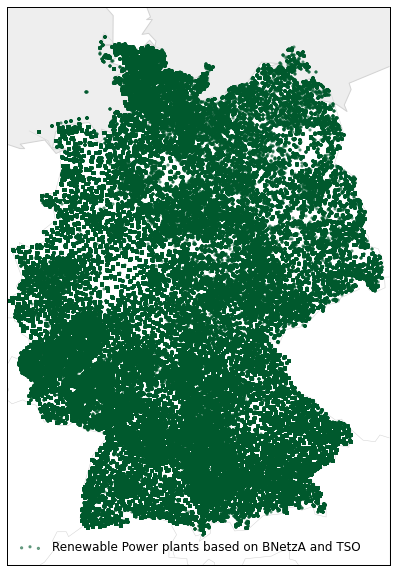

In [81]:
m = draw_germany()
# Draw map background
m.fillcontinents(color='white', lake_color='#eeeeee')
m.drawstates(color='lightgray')
m.drawcoastlines(color='lightgray')
m.drawcountries(color='lightgray')
m.drawmapboundary(fill_color='#eeeeee')

# get coordinates
lon = np.array(energymap_data.longitude)
lat = np.array(energymap_data.latitude)

# Plot PV systems entries
style = dict(s=5, marker='o', alpha=0.5, zorder=2)
m.scatter(lon,lat, latlon=True,
          label='Renewable Power plants based on BNetzA and TSO',
          color='#00592D', **style)

plt.legend(loc='lower left', frameon=False)

# Documenting the data package (meta data)

We document the data packages meta data in the specific format JSON as proposed by the Open Knowledge Foundation. See the Frictionless Data project by OKFN (http://data.okfn.org/) and the Data Package specifications (http://dataprotocols.org/data-packages/) for more details.

In order to keep the notebook more readable, we first formulate the metadata in the human-readable YAML format using a multi-line string. We then parse the string into a Python dictionary and save that to disk as a JSON file.

In [82]:
# Here we define meta data of the resulting data package.
# The meta data follows the specification at:
# http://dataprotocols.org/data-packages/

metadata = """
name: opsd-renewable-master-register-germany
title: Test data for master data register of renewable power plants in Germany.
description: This dataset is just for OPSD testing and contains the master data of Germany.
version: 0.0.2
keywords: [master data register,power plants,renewables,germany]
resources:
      path: renewable_power-plants_germany.csv
      format: csv
      mediatype: text/csv
      schema:  # Schema according to: http://dataprotocols.org/json-table-schema/        
          fields:
            - name: start_up_date
              description: Date of start up
              type: datetime
              format: YYYY-MM-DDThh:mm:ssZ  # This MUST be in ISO 8601 format of YYYY-MM-DDThh:mm:ssZ in UTC time according to http://dataprotocols.org/json-table-schema/
            - name: rated_power
              description: Rated power in kW
              type: number
              format: float
            - name: type_of_generation
              description: Type of generation / energy source
              type: number
            - name: subtype,
              description: subtype of generation
              type: text
            - name: thermal_capacity
              description: Installed thermal capacity in kW
              type: number
            - name: city
              description: City name of location
              type: text
            - name: tso
              description: Name of TSO  
              type: text    
            - name: longitude
              description: GPS Longitude coordinates
              type: number             
            - name: latitude
              description: GPS Latitude coordinates 
              type: number
            - name: eeg_id
              description: eeg remuneration number
              type: text
            - name: voltage_level
              description: Volatage level of grid connection
              type: text             
            - name: source
              description: Source name of entry
              type: text
licenses:
    - url: http://example.com/license/url/here
      name: License Name Here
      version: 1.0
      id: license-id-from-open
sources:
    - name: EnergyMap.info,
      web: http://www.energymap.info/download.html
    - name: Bundesnetzagentur - Veröffentlichung von im Anlagenregister registrierten Daten,
      web: http://www.bundesnetzagentur.de/cln_1422/DE/Sachgebiete/ElektrizitaetundGas/Unternehmen_Institutionen/ErneuerbareEnergien/Anlagenregister/Anlagenregister_Veroeffentlichung/Anlagenregister_Veroeffentlichungen_node.html
    - name: Bundesnetzagentur - Datenmeldungen und EEG-Vergütungssätze für Photovoltaikanlagen,
      web: http://www.bundesnetzagentur.de/cln_1431/DE/Sachgebiete/ElektrizitaetundGas/Unternehmen_Institutionen/ErneuerbareEnergien/Photovoltaik/DatenMeldgn_EEG-VergSaetze/DatenMeldgn_EEG-VergSaetze_node.html    
    - name: Netz-transparenz.de Informationsplattform der deutschen Übertragungsnetzbetreiber, 
      web: https://www.netztransparenz.de/de/Anlagenstammdaten.htm
maintainers:
    - name: OPSD Project,
      email: wolf-dieter.bunke@uni-flensburg.de,
      web: http://open-power-system-data.org/
views:
    # You can put hints here which kind of graphs or maps make sense to display your data. This makes the 
    # Data Package Viewer at http://data.okfn.org/tools/view automatically display visualazations of your data.
    # See http://data.okfn.org/doc/data-package#views for more details.    
# extend your datapackage.json with attributes that are not
# part of the data package spec
# you can add your own attributes to a datapackage.json, too
openpowersystemdata-enable-listing: True  # This is just an example we don't actually make use of yet.
"""

metadata = yaml.load(metadata)

datapackage_json = json.dumps(metadata, indent=4, separators=(',', ': '))

# Write Data Package to disk

Again, we follow the Frictionless Data project's suggestions (see http://data.okfn.org/) to write a data package.

The data package consists of:
 * **datapackage.json** A file containing meta data of the data package
 * ***.csv** One or multiple CSV data files
 * **README.md** A readme (which is a copy of this Jupyter Notebook converted to Markdown format)

Following this file structure allows to use a number of tools (http://data.okfn.org/tools) designed specifically for data packages.

In [83]:
path_package = 'output/datapackage_renewables'

os.makedirs(path_package, exist_ok=True)
    
energymap_data.to_csv(os.path.join(path_package,
                            'renewable_power-plants_germany.csv'))

with open(os.path.join(path_package, 'datapackage.json'), 'w') as f:
    f.write(datapackage_json)
    
##
# Make sure the filename here matches the filename of the notebook itself
##
nb_filename = 'renewable-energy-power-plants_DE.ipynb'

# Save a copy of the notebook to markdown, to serve as the package README file
subprocess.call(['jupyter', 'nbconvert', '--to', 'markdown', nb_filename])
path_readme = os.path.join(path_package, 'README.md')
try:
    os.remove(path_readme)
except Exception:
    pass
os.rename(nb_filename.replace('.ipynb', '.md'), path_readme)

FileNotFoundError: [Errno 2] No such file or directory: 'renewable-energy-power-plants_DE.md' -> 'output/datapackage_renewables/README.md'